### **Introducción a la Inteligencia Artificial en Medicina**
Taller dictado por iHEALTH

Recuerda ejecutar **TODAS** las celdas en orden

# 1.- Descargamos librerías y datos

In [1]:
!pip install -q "monai-weekly[pillow, tqdm]"
!pip install -q matplotlib
%matplotlib inline
import monai
import matplotlib
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    RandGaussianSmooth,
)
from monai.utils import set_determinism
from tabulate import tabulate

print_config()

_dummy_arr = torch.rand(1, device='cuda')

directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(f"Root dir: {root_dir}")

#!gdown 1Ig45opmPavH_WgJiGBVV446LbqFfUAEd
!gdown 1KXyvsXOTwa4Oi2A9Cee26hFMqALbPI7y
!unzip -q -o /content/BDCerebroS.zip
#!gdown 170rGaBqXh5mWagnmEMkbkLGZPdE0JS3a


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.6 MB/s eta 0:00:00
MONAI version: 1.3.dev2330
Numpy version: 1.22.4
Pytorch version: 2.0.1+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: ce84232bbde7d4c31b274f61c8ccef539c421aaa
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.12.3
gdown version: 4.6.6
TorchVision version: 0.15.2+cu118
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 1.5.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the op

## 2.- Revisar las imágenes de la base de datos

Primero verificaremos las estadísticas de la base de datos.

Tenemos 4 carpetas en la base de datos: glioma, meningioma, pituitaria y notumor.

Estos nombres de las carpetas serán las clases para clasificar

Cantidad total de imágenes: 1039
Dimensiones imágenes: 450 x 450
Nombres de las clases: ['glioma', 'meningioma', 'pituitaria', 'sintumor']
Imágenes por clase: [257, 267, 252, 263]


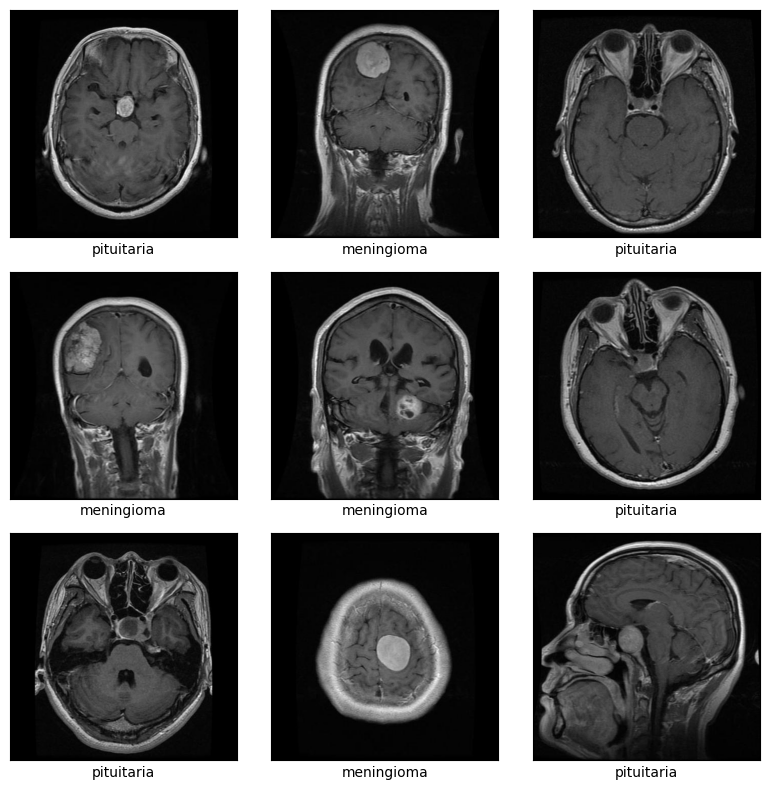

In [2]:
carpetaBD="BDCerebro"
nombres_clases = sorted(x for x in os.listdir(carpetaBD) if os.path.isdir(os.path.join(carpetaBD, x)))
cantidad_clases = len(nombres_clases)
archivos_imagenes = [
    [os.path.join(carpetaBD, nombres_clases[i], x) for x in os.listdir(os.path.join(carpetaBD, nombres_clases[i]))]
    for i in range(cantidad_clases)
]
conteo_clase = [len(archivos_imagenes[i]) for i in range(cantidad_clases)]
lista_archivos_imagenes = []
clase_imagen = []
for i in range(cantidad_clases):
    lista_archivos_imagenes.extend(archivos_imagenes[i])
    clase_imagen.extend([i] * conteo_clase[i])
num_total = len(clase_imagen)
image_width, image_height = PIL.Image.open(lista_archivos_imagenes[0]).size

print(f"Cantidad total de imágenes: {num_total}")
print(f"Dimensiones imágenes: {image_width} x {image_height}")
print(f"Nombres de las clases: {nombres_clases}")
print(f"Imágenes por clase: {conteo_clase}")

plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    im = PIL.Image.open(lista_archivos_imagenes[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(nombres_clases[clase_imagen[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

## 3.- Preparación de la lista de entrenamiento, validación y testeo

Elegimos aleatoreamente el 10% de la base de datos para validación y otro 10% para testeo. El 80% restante se usará para entrenar.

In [5]:
fraccion_validacion = 0.15
fraccion_testeo = 0.15
conteo_imagenes = len(lista_archivos_imagenes)
indices = np.arange(conteo_imagenes)
np.random.shuffle(indices)

test_split = int(fraccion_testeo * conteo_imagenes)
val_split = int(fraccion_validacion * conteo_imagenes) + test_split
test_indices = indices[:test_split]
val_indices = indices[test_split:val_split]
train_indices = indices[val_split:]

train_x = [lista_archivos_imagenes[i] for i in train_indices]
train_y = [clase_imagen[i] for i in train_indices]
val_x = [lista_archivos_imagenes[i] for i in val_indices]
val_y = [clase_imagen[i] for i in val_indices]
test_x = [lista_archivos_imagenes[i] for i in test_indices]
test_y = [clase_imagen[i] for i in test_indices]

train_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
    ]
)

val_transforms = Compose([LoadImage(image_only=True), EnsureChannelFirst(), ScaleIntensity()])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=cantidad_clases)])

class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, archivos_imagenes, labels, transforms):
        self.archivos_imagenes = archivos_imagenes
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.archivos_imagenes)

    def __getitem__(self, index):
        return self.transforms(self.archivos_imagenes[index]), self.labels[index]


train_ds = MedNISTDataset(train_x, train_y,train_transforms)
train_loader = DataLoader(train_ds, batch_size=20, shuffle=True, num_workers=2)

val_ds = MedNISTDataset(val_x, val_y, val_transforms)
val_loader = DataLoader(val_ds, batch_size=20, num_workers=2)

test_ds = MedNISTDataset(test_x, test_y, val_transforms)
test_loader = DataLoader(test_ds, batch_size=20, num_workers=2)

print(f"Imágenes de entrenamiento: {len(train_x)}, Imágenes de validación: " f"{len(val_x)}, Imágenes de testeo: {len(test_x)}")

Imágenes de entrenamiento: 729, Imágenes de validación: 155, Imágenes de testeo: 155


## 4.- Definimos la red y el optimizador

1. Fijamos el learning rate que define qué tanto se modifica nuestro modelo por batch.
1. Fijamos la cantidad de épocas de entrenamiento, así como las transformaciones que requiere la imagen


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=cantidad_clases).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epocas = 5
val_interval = 1
auc_metric = ROCAUCMetric()
set_determinism(seed=0)

## 5.- Entrenamiento del modelo


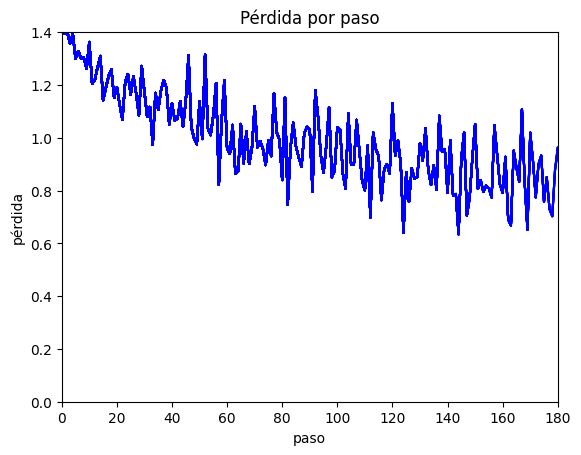

entrenamiento completado, mejor métrica: 0.9089  en la época: 5


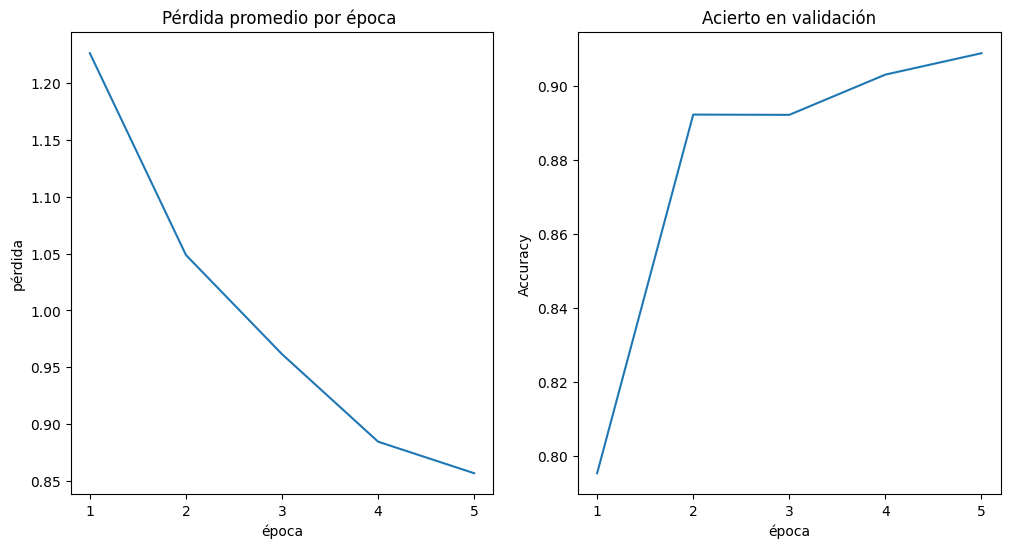

In [7]:
assert root_dir and os and torch and model, "Recuerda correr todas las celdas anteriores"
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

mejor_metrica = -1
mejor_metrica_epoca = -1
epoca_loss_values = []
metric_values = []

fig = plt.figure()
current_loss = 1
losses = []
plt.axis([0, 10, 0, 1])
n_steps = 36*max_epocas
plt.ylim(0, 1.4)
plt.xlim(0, n_steps)
plt.title("Pérdida por paso")
plt.xlabel("paso")
plt.ylabel("pérdida")

for epoca in range(max_epocas):
    print("-" * 10)
    print(f"epoca {epoca + 1}/{max_epocas}")
    model.train()
    epoca_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoca_loss += loss.item()
        #print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"función de pérdida: {loss.item():.4f}")

        losses.append(loss.item())
        plt.plot(np.arange(len(losses)), losses, color='blue')
        display(fig)
        clear_output(wait=True)


        epoca_len = len(train_ds) // train_loader.batch_size
    epoca_loss /= step
    epoca_loss_values.append(epoca_loss)
    #print(f"época {epoca + 1} pérdida promedio: {epoca_loss:.4f}")



    if (epoca + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > mejor_metrica:
                mejor_metrica = result
                mejor_metrica_epoca = epoca + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "mejor_metrica_model.pth"))

plt.show()
print("\nEntrenamiento completado")
print(f"mejor métrica: {mejor_metrica:.4f} " f" en la época: {mejor_metrica_epoca}")

plt.figure("entrenamiento", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Pérdida promedio por época ")
x = [i + 1 for i in range(len(epoca_loss_values))]
y = epoca_loss_values
plt.xlabel("época")
plt.ylabel("pérdida")
plt.xticks(np.arange(len(epoca_loss_values)) + 1)
plt.plot(x, y)

plt.subplot(1, 2, 2)
plt.title("Acierto en validación")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("época")
plt.xticks(np.arange(len(metric_values)) + 1)
plt.ylabel("Acierto")
plt.plot(x, y)
plt.show()

## 6.- Evaluación de los resultados



<ipython-input-8-d4c6185d2cfb>:23: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n_test_samples, n_test_samples, i + 1)


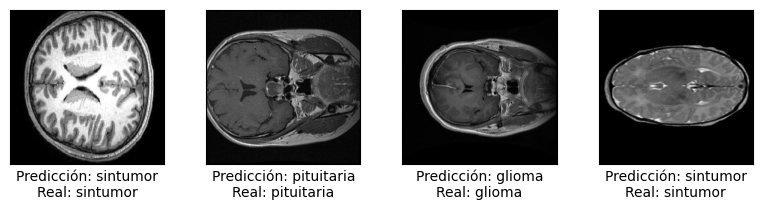

In [8]:
model_path_dir = os.path.join(root_dir, "mejor_metrica_model.pth")
# model_path_dir = '/content/mejor_metrica_model_epoch10.pth'

model.load_state_dict(torch.load(model_path_dir))
_ = model.eval()


n_test_samples = 4
images, labels = tuple(zip(*[
    test_ds[idx]
    for idx in np.random.randint(len(test_ds), size=n_test_samples)
]))
images = torch.stack(images).to(device)
labels = np.array(labels)

with torch.no_grad():
  preds = model(images.cuda()).argmax(dim=1)

images = images.squeeze(1).cpu().numpy()
preds = preds.cpu().numpy()
plt.subplots(1, n_test_samples, figsize=(8, 8))
for i, (image, pred, label) in enumerate(zip(images, preds, labels)):
    plt.subplot(n_test_samples, n_test_samples, i + 1)
    plt.xlabel(f"Predicción: {nombres_clases[pred]}\nReal: {nombres_clases[label]}")
    plt.imshow(image, cmap="gray")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

## 7.- Resumen de los resultados



In [10]:
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

data = np.array([nombres_clases,precision_score(y_true, y_pred, average=None), recall_score(y_true, y_pred, average=None)])
data =np.transpose(data)

col_names = ["Clase","Precisión","Exhaustividad"]

print(tabulate(data, headers=col_names))

print("\nAcierto total: ", accuracy_score(y_true, y_pred))



Clase         Precisión    Exhaustividad
----------  -----------  ---------------
glioma         0.54717          0.805556
meningioma     0.666667         0.390244
pituitaria     0.622222         0.777778
sintumor       0.939394         0.738095

Acierto total:  0.6709677419354839


Este tutorial fue realizado en base a **Medical Image Classification Tutorial with the MedNIST Dataset** Copyright (c) MONAI Consortium  





